<a href="https://colab.research.google.com/github/tkg31302/Algo-trading/blob/main/Momentum_based_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Momentum based Trading

In [9]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

N = 50
T = 7
R = 0.8
M = 5
F = 0.005
D = 500
B = 10000

In [10]:
def GetData(NameOfFile):
  return pd.DataFrame(pd.read_csv(NameOfFile, usecols = ['datadate','tic','adjcp']))

In [11]:
def PartitionData(Data):
  DateToIndex = {}
  for e in range(len(Data['datadate'])):
    DateToIndex.setdefault(str(Data['datadate'][e]),e)
  return [np.array_split(Data,2926), DateToIndex]

In [12]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
  NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
  i = 0
  while i >= 0:
    x = str(NdaysAgo - datetime.timedelta(days = i)).replace('-','')
    if (x in DateToIndex.keys()):
      break
    i += 1
  temp = x
  Momentum = np.array(PartitionedDataFrameList[DateToIndex[today] % 2926]['adjcp']) - np.array(PartitionedDataFrameList[DateToIndex[temp] % 2926]['adjcp'])
  Sum = np.array(PartitionedDataFrameList[DateToIndex[today] % 2926]['adjcp'])
  for i in range((DateToIndex[temp] + 1), (DateToIndex[today]),30):
    Sum += np.array(PartitionedDataFrameList[i % 2926]['adjcp'])
  return Momentum * N / Sum

In [13]:
def GetBalanced(prices, weights,balance):
  copy = np.flip(np.sort(weights))
  for i in range(M,len(weights)):
    copy[i] = 0
  for i in range(len(weights)):
    if weights[i] not in copy:
      weights[i] = 0
    elif weights[i] < 0:
      weights[i] = 0
  sum = np.sum(weights)
  if (sum <= 0):
    return np.zeros(30, dtype = float)
  weights /= sum
  sum = np.sum(weights * prices)
  return (balance / sum) * weights

In [14]:
class PortFolio:
  def __init__(self, balance, numStocks, prices):
    self.balance = balance
    self.numStocks = numStocks
    self.prices = prices

  def SellStock(self, index):
    self.balance += self.numStocks[index] * self.prices[index] * (1 - F)
    self.numStocks[index] = 0

  def BuyStock(self, index, number):
    self.balance -= number * self.prices[index] * (1 + F)

  def CalculateNetWorth(self):
    return self.balance + np.sum(self.numStocks * self.prices) * (1 - F)

  def ChangePricesTo(self, newPriceVector):
    self.prices = newPriceVector

  def RebalancePortFolio(self, newWeights):
    balanceCopy = self.balance + np.sum(self.numStocks * self.prices) * (1 - F)
    newStocks = GetBalanced(self.prices, newWeights, balanceCopy)
    for i in range(30):
      balanceCopy -= self.prices[i] * newStocks[i] * (1 + F)
    if balanceCopy + np.sum(self.prices * newStocks) * (1 - F) + B * (1 - R) >= self.CalculateNetWorth():
      self.balance = balanceCopy
      self.numStocks = newStocks

In [15]:
Data = GetData("DATA.csv")
List = PartitionData(Data)
PartitionedData = List[0]
DateToIndex = List[1]

myPortfolio = PortFolio(B * R,np.zeros(30, dtype = float),np.array(PartitionedData[int(list(DateToIndex.keys())[N]) % 2926]['adjcp']))
NetWorthAfterEachTrade = [myPortfolio.CalculateNetWorth() + B * (1 - R)]

for i in range((N + 1),len(PartitionedData)):
  today = list(DateToIndex.keys())[i]
  myPortfolio.ChangePricesTo(np.array(PartitionedData[int(today) % 2926]['adjcp']))
  NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth() + B * (1 - R))
  if (i % T == 0):
    myPortfolio.RebalancePortFolio(GetMomentumBasedPriority(PartitionedData, DateToIndex, today))

In [16]:
def VisualizeData(FinalData):
  plt.plot(FinalData)
  plt.show()

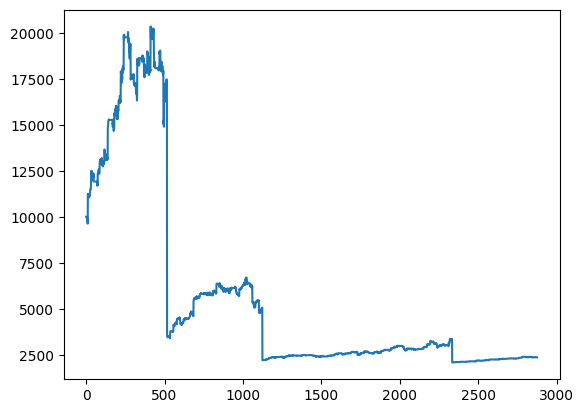

In [18]:
VisualizeData(NetWorthAfterEachTrade)